## Ce notebook permet de réaliser la détection d'une arme à feu sur une image ( lié à la page 1_Detection_Image.py)

#### Nous utiliserons un algorithme de Deep Learning, appelé CNN ( Convolutionnal Central Neural Networks) pour réaliser la classification des images multi-labels

In [1]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


## Charger et préparer les données

https://www.kaggle.com/datasets/syedwajeeh19/weapon-detection-dataset-for-yolov3/data

In [2]:
# Charger les CSV contenant les labels pour chaque ensemble de données
train_labels_path = "../Weapons.v2i.multiclass/train/_classes.csv"
test_labels_path = "../Weapons.v2i.multiclass/test/_classes.csv"
validation_labels_path = "../Weapons.v2i.multiclass/valid/_classes.csv"



In [3]:
# Charger les données pour l'ensemble d'entraînement, de validation et de test à partir des fichiers CSV
train_labels = pd.read_csv(train_labels_path, skipinitialspace=True)
test_labels = pd.read_csv(test_labels_path, skipinitialspace=True)
valid_labels = pd.read_csv(validation_labels_path, skipinitialspace=True)

In [4]:
# Chemins vers les répertoires contenant les images pour chaque ensemble de données
train_dir = "../Weapons.v2i.multiclass/train/"
test_dir = "../Weapons.v2i.multiclass/test/"
valid_dir = "../Weapons.v2i.multiclass/valid/"


## Génération d'image

In [5]:

# Paramètres des images
image_size = (150, 150)
batch_size = 32


# # Mise en place des générateurs d'images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col="filename",
    y_col=["Gun","Knife","Rifle"],  # Utilisez des majuscules pour correspondre aux noms de colonnes dans le CSV
    target_size=image_size,
    batch_size=batch_size,
    class_mode="raw"
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_labels,
    directory=valid_dir,
    x_col="filename",
    y_col=["Gun","Knife","Rifle"],  # Utilisez des majuscules pour correspondre aux noms de colonnes dans le CSV
    target_size=image_size,
    batch_size=batch_size,
    class_mode="raw"
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=test_dir,
    x_col="filename",
    y_col=["Gun","Knife","Rifle"],  # Utilisez des majuscules pour correspondre aux noms de colonnes dans le CSV
    target_size=image_size,
    batch_size=batch_size,
    class_mode="raw"
)


Found 279 validated image filenames.
Found 80 validated image filenames.
Found 39 validated image filenames.


## Création du modèle

In [6]:
# Paramètres des images
image_size = (150, 150)
batch_size = 32

# Mise en place des générateurs d'images
print("Chargement des données...")
print("Répertoire de formation:", train_dir)
print("Répertoire de validation:", valid_dir)
print("Répertoire de test:", test_dir)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col="filename",
    y_col=["Gun","Knife","Rifle"],
    target_size=image_size,
    batch_size=batch_size,
    class_mode="raw"
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_labels,
    directory=valid_dir,
    x_col="filename",
    y_col=["Gun","Knife","Rifle"],
    target_size=image_size,
    batch_size=batch_size,
    class_mode="raw"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory=test_dir,
    x_col="filename",
    y_col=["Gun","Knife","Rifle"],
    target_size=image_size,
    batch_size=batch_size,
    class_mode="raw"
)

# Charger l'architecture InceptionV3 pré-entraînée sans les couches fully connected
print("Chargement du modèle InceptionV3...")
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congeler les couches du modèle pré-entraîné pour empêcher leur mise à jour lors de l'entraînement
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches fully connected personnalisées au-dessus de l'architecture pré-entraînée
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # 3 classes : Gun, Knife, Rifle

# Définir le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle en utilisant les générateurs d'images
print("Entraînement du modèle...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

# Évaluer le modèle sur l'ensemble de test
print("Évaluation du modèle sur l'ensemble de test...")
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)


Chargement des données...
Répertoire de formation: ../Weapons.v2i.multiclass/train/
Répertoire de validation: ../Weapons.v2i.multiclass/valid/
Répertoire de test: ../Weapons.v2i.multiclass/test/
Found 279 validated image filenames.
Found 80 validated image filenames.
Found 39 validated image filenames.
Chargement du modèle InceptionV3...
Entraînement du modèle...
Epoch 1/10
9/9 [==============================] - 27s 2s/step - loss: 6.5296 - accuracy: 0.5269 - val_loss: 3.4029 - val_accuracy: 0.4500
Epoch 2/10
9/9 [==============================] - 8s 852ms/step - loss: 0.8649 - accuracy: 0.7957 - val_loss: 0.8887 - val_accuracy: 0.8125
Epoch 3/10
9/9 [==============================] - 7s 804ms/step - loss: 0.3582 - accuracy: 0.8996 - val_loss: 0.9756 - val_accuracy: 0.7500
Epoch 4/10
9/9 [==============================] - 7s 722ms/step - loss: 0.1465 - accuracy: 0.9391 - val_loss: 0.5788 - val_accuracy: 0.8625
Epoch 5/10
9/9 [==============================] - 7s 777ms/step - loss: 0.07

## Sauvegarde du modèle 

In [7]:

model_save_path = r'./model.h5'

model.save(model_save_path)

print("Le modèle a été sauvegardé avec succès à l'emplacement :", model_save_path)

Le modèle a été sauvegardé avec succès à l'emplacement : ./model.h5


# Affichage de la matrice de confusion du modèle

2/2 [==============================] - 3s 172ms/step


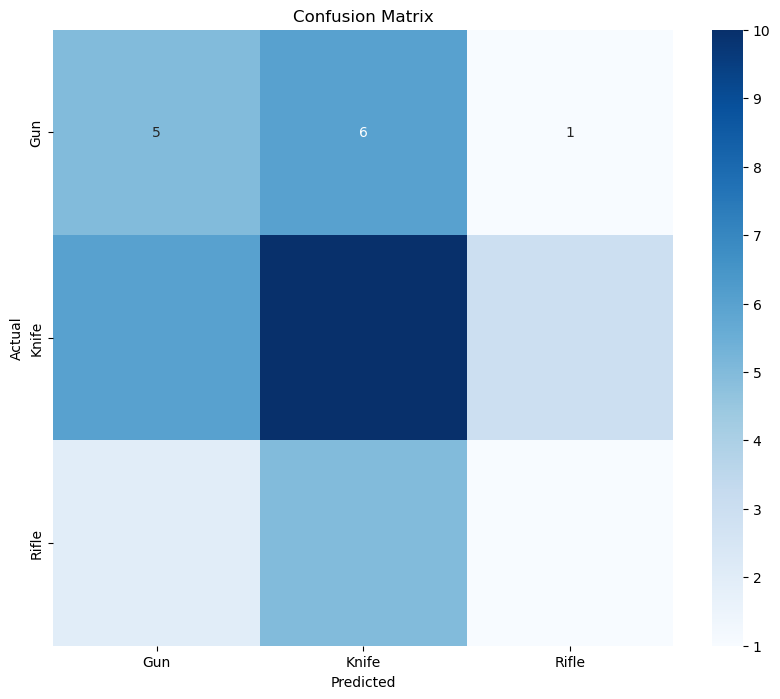

In [8]:
# affichage de la matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédire les classes pour l'ensemble de test
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Convertir les étiquettes de l'ensemble de test en classes
y_true = test_labels[["Gun","Knife","Rifle"]].to_numpy()
y_true = np.argmax(y_true, axis=1)

# Créer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["Gun","Knife","Rifle"], yticklabels=["Gun","Knife","Rifle"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
conf_matrix

array([[ 5,  6,  1],
       [ 6, 10,  3],
       [ 2,  5,  1]], dtype=int64)